In [1]:
import os
import matplotlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
def rbfkernel(X1, X2, gamma):
    return np.exp(-gamma*cdist(X1, X2, 'sqeuclidean'))


def polykernel(X):
    K = np.zeros(shape=(len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            k = 1 + np.dot(X[i].T,X[j]) ## K(i,j) = ( 1 + x(i).T . x(j) )^p
            k = k**2
            K[i][j] = k
    return K


def read_image(path, H, W):
    pics = os.listdir(path)
    images = np.zeros((W*H, len(pics)))
    labels = np.zeros(len(pics)).astype('uint8')
    for pic, i in zip(pics, np.arange(len(pics))):
        labels[i] = int(pic.split('.')[0][7:9])-1
        image = np.asarray(Image.open(os.path.join(path,pic)).resize((W,H),Image.ANTIALIAS)).flatten()
        images[:,i] = image

    return images, labels


def print_face(X, num, H, W):
    print("fisherface: ")
    n = int(num**0.5)
    axes = []
    fig = plt.figure()
    for i in range(num):
        axes.append(fig.add_subplot(n, n, i+1) )
        axes[-1].axis('off')
        plt.imshow(X[:,i].reshape(H,W), cmap='gray')
        
    fig.tight_layout()
    plt.show()
    

def print_reconstruction(X_original, X_reconstruction, num, H, W):
    print("Original: ")
    randint = np.random.choice(X_original.shape[1],num)
    axes = []
    fig = plt.figure()
    for i in range(num):
        axes.append(fig.add_subplot(1, num, i+1) )
        axes[-1].axis('off')
        plt.imshow(X_original[:,randint[i]].reshape(H,W),cmap='gray')
    fig.tight_layout()
    plt.show()
    
    print("Reconstruction: ")
    axes = []
    fig = plt.figure()
    for i in range(num):
        axes.append(fig.add_subplot(1, num, i+1) )
        axes[-1].axis('off')
        plt.imshow(X_reconstruction[:,randint[i]].reshape(H,W),cmap='gray')
        
    fig.tight_layout()
    plt.show()
    
    
def performance(X_test,y_test,Z_train,y_train,U,X_mean=None,k=3):
    if X_mean is None:
        X_mean=np.zeros((X_test.shape[0],1))

    # reduce dim (projection)
    Z_test=U.T@(X_test-X_mean)

    # k-nn
    predicted_y=np.zeros(Z_test.shape[1])
    for i in range(Z_test.shape[1]):
        distance=np.zeros(Z_train.shape[1])
        for j in range(Z_train.shape[1]):
            distance[j]=np.sum(np.square(Z_test[:,i]-Z_train[:,j]))
        sort_index=np.argsort(distance)
        nearest_neighbors=y_train[sort_index[:k]]
        unique, counts = np.unique(nearest_neighbors, return_counts=True)
        nearest_neighbors=[k for k,v in sorted(dict(zip(unique, counts)).items(), 
                                               key=lambda item: -item[1])]
        predicted_y[i]=nearest_neighbors[0]

    acc=np.count_nonzero((y_test-predicted_y)==0)/len(y_test)
    return acc

In [3]:
# SVD = U@Sigma@V.T
def pca(X, num_dim=None):
    # step 1: around center
    X_mean = np.mean(X, axis=1).reshape(-1, 1)
    X_center = X - X_mean      
    
    # step 2: X.T@X to caculate sigma&V
    eigenvalues, eigenvectors = np.linalg.eig(X_center.T @ X_center) 
    print("V shape: ", eigenvectors.shape)
    
    # step 3: sort eigenvalue big 2 small
    sort_index = np.argsort(-eigenvalues)       
    
    # step 4: delete eigenvalue<0 
    if num_dim is None:
        for eigenvalue, i in zip(eigenvalues[sort_index], 
                                 np.arange(len(eigenvalues))):
            if eigenvalue <= 0:                        
                sort_index = sort_index[:i]
                break
    else:
        sort_index = sort_index[:num_dim]

    eigenvalues = eigenvalues[sort_index]
    
    # step 5: U = (1/sigma)X@V
    eigenvectors = X_center@eigenvectors[:, sort_index]
    eigenvectors_norm = np.linalg.norm(eigenvectors,axis=0)
    eigenvectors = eigenvectors/eigenvectors_norm
    print("PCA U shape: ", eigenvectors.shape)

    return eigenvalues, eigenvectors, X_mean

# LDA

In [4]:
def lda(X,y,num_dim=None):
    N = X.shape[0]
    X_mean = np.mean(X, axis=1).reshape(-1, 1)

    classes_mean = np.zeros((N, 15))  # 15 classes
    for i in range(X.shape[1]):
        classes_mean[:, y[i]] += X[:, y[i]]
    classes_mean = classes_mean / 9

    # within-class scatter
    S_within = np.zeros((N, N))
    for i in range(X.shape[1]):
        d = X[:, y[i]].reshape(-1,1) - classes_mean[:, y[i]].reshape(-1,1)
        S_within += d @ d.T

    # between-class scatter
    S_between = np.zeros((N, N))
    for i in range(15):
        d = classes_mean[:, i].reshape(-1,1) - X_mean
        S_between += 9 * d @ d.T

    eigenvalues,eigenvectors=np.linalg.eig(np.linalg.inv(S_within)@S_between)
    sort_index=np.argsort(-eigenvalues)
    if num_dim is None:
        sort_index=sort_index[:-1]  # reduce 1 dim
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')

    return eigenvalues,eigenvectors

In [11]:
def lda_main():
    filepath = os.path.join('Yale_Face_Database', 'Training')
    H, W = 231, 195
    X, y = read_image(filepath, H, W)
    accs = []
    
    for num_dim in range(3,136):
        eigenvalues_pca, eigenvectors_pca, X_mean = pca(X, num_dim=num_dim)
        X_pca = eigenvectors_pca.T@(X - X_mean)

        eigenvalues_lda, eigenvectors_lda = lda(X_pca, y)

        # Transform matrix
        U = eigenvectors_pca@eigenvectors_lda
        print('LDA U shape: {}'.format(U.shape))

        # print top 25 eigenface
        print_face(U,25,H,W)

        # reduce dim (projection)
        Z = U.T@X

        # reconstruction
        X_reconstruction = U@Z + X_mean
        print_reconstruction(X,X_reconstruction,10,H,W)

        # accuracy
        filepath = os.path.join('Yale_Face_Database', 'Testing')
        X_test, y_test = read_image(filepath, H, W)

        for k in range(9, 10):
            acc = performance(X_test, y_test, Z, y, U, X_mean, k = k)
            accs.append(acc)
            print('num_dim: {}, k: {} ,acc: {:.2f}%'.format(num_dim, k, acc * 100))
    return accs

In [12]:
accs = lda_main()

V shape:  (135, 135)
PCA U shape:  (45045, 3)
LDA U shape: (45045, 2)
num_dim: 3, k: 9 ,acc: 6.67%
V shape:  (135, 135)
PCA U shape:  (45045, 4)
LDA U shape: (45045, 3)
num_dim: 4, k: 9 ,acc: 6.67%
V shape:  (135, 135)
PCA U shape:  (45045, 5)
LDA U shape: (45045, 4)
num_dim: 5, k: 9 ,acc: 6.67%
V shape:  (135, 135)
PCA U shape:  (45045, 6)
LDA U shape: (45045, 5)
num_dim: 6, k: 9 ,acc: 6.67%
V shape:  (135, 135)
PCA U shape:  (45045, 7)
LDA U shape: (45045, 6)
num_dim: 7, k: 9 ,acc: 6.67%
V shape:  (135, 135)
PCA U shape:  (45045, 8)
LDA U shape: (45045, 7)
num_dim: 8, k: 9 ,acc: 13.33%
V shape:  (135, 135)
PCA U shape:  (45045, 9)
LDA U shape: (45045, 8)
num_dim: 9, k: 9 ,acc: 20.00%
V shape:  (135, 135)
PCA U shape:  (45045, 10)
LDA U shape: (45045, 9)
num_dim: 10, k: 9 ,acc: 30.00%
V shape:  (135, 135)
PCA U shape:  (45045, 11)
LDA U shape: (45045, 10)
num_dim: 11, k: 9 ,acc: 20.00%
V shape:  (135, 135)
PCA U shape:  (45045, 12)
LDA U shape: (45045, 11)
num_dim: 12, k: 9 ,acc: 30.0

PCA U shape:  (45045, 83)
LDA U shape: (45045, 82)
num_dim: 83, k: 9 ,acc: 30.00%
V shape:  (135, 135)
PCA U shape:  (45045, 84)
LDA U shape: (45045, 83)
num_dim: 84, k: 9 ,acc: 16.67%
V shape:  (135, 135)
PCA U shape:  (45045, 85)
LDA U shape: (45045, 84)
num_dim: 85, k: 9 ,acc: 16.67%
V shape:  (135, 135)
PCA U shape:  (45045, 86)
LDA U shape: (45045, 85)
num_dim: 86, k: 9 ,acc: 6.67%
V shape:  (135, 135)
PCA U shape:  (45045, 87)
LDA U shape: (45045, 86)
num_dim: 87, k: 9 ,acc: 13.33%
V shape:  (135, 135)
PCA U shape:  (45045, 88)
LDA U shape: (45045, 87)
num_dim: 88, k: 9 ,acc: 30.00%
V shape:  (135, 135)
PCA U shape:  (45045, 89)
LDA U shape: (45045, 88)
num_dim: 89, k: 9 ,acc: 30.00%
V shape:  (135, 135)
PCA U shape:  (45045, 90)
LDA U shape: (45045, 89)
num_dim: 90, k: 9 ,acc: 26.67%
V shape:  (135, 135)
PCA U shape:  (45045, 91)
LDA U shape: (45045, 90)
num_dim: 91, k: 9 ,acc: 30.00%
V shape:  (135, 135)
PCA U shape:  (45045, 92)
LDA U shape: (45045, 91)
num_dim: 92, k: 9 ,acc:

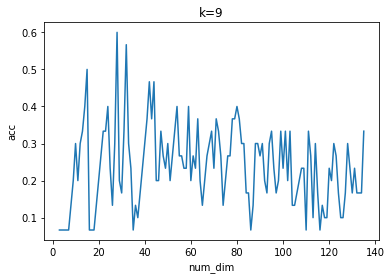

In [13]:
num_dim = [i for i in range(3,136)]
plt.plot(num_dim, accs)
plt.title('k=9')
plt.xlabel('num_dim')
plt.ylabel('acc')
plt.show()

# kernel LDA

In [ ]:
def lda(X,y,num_dim=None):
    # step0: kernel
    if kernel == 'RBF':
        gamma = 0.01
        X = rbfkernel(X, X, gamma)
        
    elif kernel == 'polynomial':
        X = polykernel(X)
    
    
    N = X.shape[0]
    X_mean = np.mean(X, axis=1).reshape(-1, 1)

    classes_mean = np.zeros((N, 15))  # 15 classes
    for i in range(X.shape[1]):
        classes_mean[:, y[i]] += X[:, y[i]]
    classes_mean = classes_mean / 9

    # within-class scatter
    S_within = np.zeros((N, N))
    for i in range(X.shape[1]):
        d = X[:, y[i]].reshape(-1,1) - classes_mean[:, y[i]].reshape(-1,1)
        S_within += d @ d.T

    # between-class scatter
    S_between = np.zeros((N, N))
    for i in range(15):
        d = classes_mean[:, i].reshape(-1,1) - X_mean
        S_between += 9 * d @ d.T

    eigenvalues,eigenvectors=np.linalg.eig(np.linalg.inv(S_within)@S_between)
    sort_index=np.argsort(-eigenvalues)
    if num_dim is None:
        sort_index=sort_index[:-1]  # reduce 1 dim
    else:
        sort_index=sort_index[:num_dim]

    eigenvalues=np.asarray(eigenvalues[sort_index].real,dtype='float')
    eigenvectors=np.asarray(eigenvectors[:,sort_index].real,dtype='float')

    return eigenvalues,eigenvectors